In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (classification_report, accuracy_score, 
                            confusion_matrix, roc_curve, auc, 
                            roc_auc_score, f1_score)
from sklearn.preprocessing import label_binarize
import os

# Create output directory
OUTPUT_DIR = './sentiment_output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [2]:
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("="*70)
print(" TWITTER SENTIMENT ANALYSIS - ADVANCED ML MODELS")
print("="*70)


 TWITTER SENTIMENT ANALYSIS - ADVANCED ML MODELS


In [3]:
# ============================================================================
# STEP 1: LOAD AND PREPARE DATA
# ============================================================================
print("\n[1] Loading Data...")
df_train = pd.read_csv("./twitter_training.csv")
df_val = pd.read_csv("./twitter_validation.csv")

# Rename columns
df_train.columns = ['ID', 'platform', 'sentimen', 'text']
df_val.columns = ['ID', 'platform', 'sentimen', 'text']

# Drop unnecessary columns
df_train = df_train.drop(["ID", "platform"], axis=1)
df_val = df_val.drop(["ID", "platform"], axis=1)

# Clean data
print("[2] Cleaning Data...")
for col_idx in range(len(df_train.columns)):
    df_train = df_train[df_train.iloc[:, col_idx] != '?']
    df_train = df_train[df_train.iloc[:, col_idx] != '']
    df_train = df_train[~df_train.iloc[:, col_idx].isna()]

for col_idx in range(len(df_val.columns)):
    df_val = df_val[df_val.iloc[:, col_idx] != '?']
    df_val = df_val[df_val.iloc[:, col_idx] != '']
    df_val = df_val[~df_val.iloc[:, col_idx].isna()]

df_train.drop_duplicates(keep='first', inplace=True)
df_val.drop_duplicates(keep='first', inplace=True)

print(f"   Training samples: {len(df_train)}")
print(f"   Validation samples: {len(df_val)}")
print(f"\n   Sentiment Distribution (Training):")
for sent, count in df_train['sentimen'].value_counts().items():
    print(f"      {sent}: {count} ({count/len(df_train)*100:.1f}%)")


[1] Loading Data...
[2] Cleaning Data...
   Training samples: 69768
   Validation samples: 998

   Sentiment Distribution (Training):
      Negative: 21237 (30.4%)
      Positive: 19137 (27.4%)
      Neutral: 17110 (24.5%)
      Irrelevant: 12284 (17.6%)


In [4]:
# ============================================================================
# STEP 2: TEXT PREPROCESSING
# ============================================================================
print("\n[3] Preprocessing Text...")

def preprocess_text(text):
    """Clean and preprocess tweet text"""
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())
    
    return text

df_train["clean_text"] = df_train["text"].apply(preprocess_text)
df_val["clean_text"] = df_val["text"].apply(preprocess_text)

# Remove empty texts
df_train = df_train[df_train['clean_text'].str.strip() != '']
df_val = df_val[df_val['clean_text'].str.strip() != '']

print(f"   Preprocessed {len(df_train)} training texts")
print(f"   Preprocessed {len(df_val)} validation texts")



[3] Preprocessing Text...
   Preprocessed 69610 training texts
   Preprocessed 998 validation texts


In [5]:
# ============================================================================
# STEP 3: TF-IDF VECTORIZATION
# ============================================================================
print("\n[4] Creating TF-IDF Features...")
tfidf = TfidfVectorizer(max_features=17000, ngram_range=(1, 2))

X_train = tfidf.fit_transform(df_train['clean_text'])
X_test = tfidf.transform(df_val['clean_text'])
y_train = df_train['sentimen']
y_test = df_val['sentimen']

print(f"   Feature matrix shape: {X_train.shape}")
print(f"   Vocabulary size: {len(tfidf.vocabulary_)}")



[4] Creating TF-IDF Features...
   Feature matrix shape: (69610, 17000)
   Vocabulary size: 17000


In [6]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Comprehensive evaluation function for multi-class classification
    """
    print(f"\n{'='*70}")
    print(f" EVALUATING: {model_name}")
    print('='*70)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print(f"\n📊 Overall Metrics:")
    print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   F1-Score:  {f1:.4f} (macro)")
    
    # Classification report
    print(f"\n📋 Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y_test),
                yticklabels=np.unique(y_test))
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    output_file = os.path.join(OUTPUT_DIR, f'confusion_matrix_{model_name.replace(" ", "_").lower()}.png')
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()  
    
    # ROC-AUC
    try:
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test)
        elif hasattr(model, 'decision_function'):
            y_proba = model.decision_function(X_test)
        else:
            y_proba = None
        
        if y_proba is not None:
            classes = model.classes_
            y_test_bin = label_binarize(y_test, classes=classes)
            
            if y_test_bin.shape[1] == 1:
                y_test_bin = np.hstack([1 - y_test_bin, y_test_bin])
            
            roc_auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
            print(f"\n🎯 ROC-AUC Score: {roc_auc:.4f} (macro)")
    except Exception as e:
        print(f"\n⚠️ ROC-AUC calculation skipped")
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'f1_score': f1,
        'confusion_matrix': cm
    }

print("✓ Evaluation function ready")

✓ Evaluation function ready



[6] Training Random Forest Classifier...
   ✓ Training completed in 1.54 seconds

 EVALUATING: Random Forest

📊 Overall Metrics:
   Accuracy:  0.5120 (51.20%)
   F1-Score:  0.4271 (macro)

📋 Classification Report:
              precision    recall  f1-score   support

  Irrelevant       1.00      0.04      0.08       171
    Negative       0.39      0.95      0.56       266
     Neutral       0.88      0.29      0.44       285
    Positive       0.67      0.61      0.64       276

    accuracy                           0.51       998
   macro avg       0.74      0.47      0.43       998
weighted avg       0.71      0.51      0.46       998



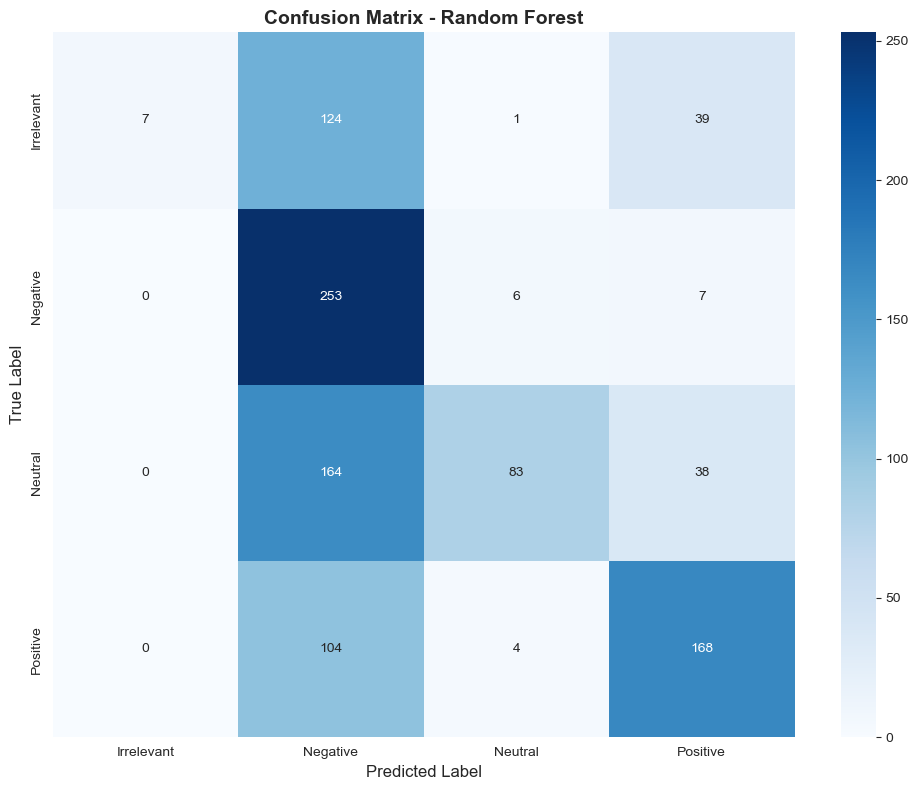


🎯 ROC-AUC Score: 0.8938 (macro)


In [7]:
# ============================================================================
# STEP 6: TRAIN RANDOM FOREST
# ============================================================================
print("\n[6] Training Random Forest Classifier...")
start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf_model.fit(X_train, y_train)

rf_time = time.time() - start_time
print(f"   ✓ Training completed in {rf_time:.2f} seconds")

rf_results = evaluate_model(rf_model, X_test, y_test, "Random Forest")


[7] Training Linear SVM...
   ✓ Training completed in 3.54 seconds

 EVALUATING: Linear SVM

📊 Overall Metrics:
   Accuracy:  0.9569 (95.69%)
   F1-Score:  0.9566 (macro)

📋 Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.95      0.95      0.95       171
    Negative       0.96      0.97      0.96       266
     Neutral       0.97      0.95      0.96       285
    Positive       0.94      0.95      0.95       276

    accuracy                           0.96       998
   macro avg       0.96      0.96      0.96       998
weighted avg       0.96      0.96      0.96       998



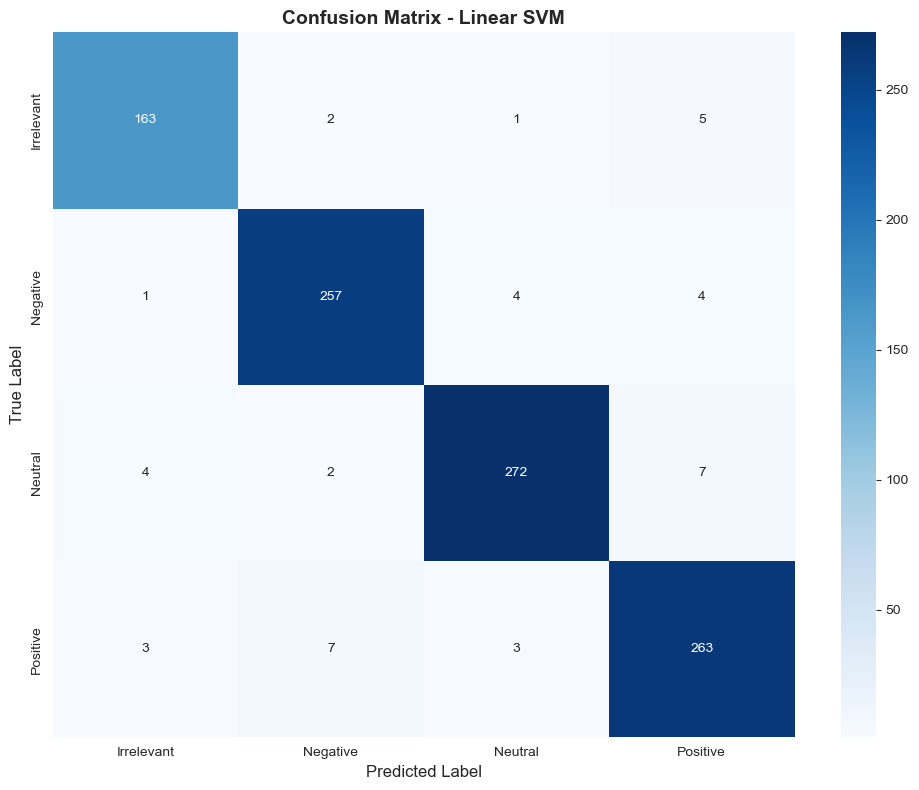


🎯 ROC-AUC Score: 0.9938 (macro)


In [8]:
# ============================================================================
# STEP 7: TRAIN LINEAR SVM
# ============================================================================
print("\n[7] Training Linear SVM...")
start_time = time.time()

svm_linear_model = LinearSVC(C=1.0, max_iter=1000, random_state=42)
svm_linear_model.fit(X_train, y_train)

svm_linear_time = time.time() - start_time
print(f"   ✓ Training completed in {svm_linear_time:.2f} seconds")

svm_linear_results = evaluate_model(svm_linear_model, X_test, y_test, "Linear SVM")


[8] Training RBF SVM (this may take longer)...
   Note: RBF SVM is slower but can capture non-linear patterns
   Training on subset of 10,000 samples for speed...
   ✓ Training completed in 150.63 seconds

 EVALUATING: RBF SVM

📊 Overall Metrics:
   Accuracy:  0.7615 (76.15%)
   F1-Score:  0.7479 (macro)

📋 Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.84      0.53      0.65       171
    Negative       0.71      0.86      0.78       266
     Neutral       0.84      0.75      0.80       285
    Positive       0.72      0.81      0.76       276

    accuracy                           0.76       998
   macro avg       0.78      0.74      0.75       998
weighted avg       0.77      0.76      0.76       998



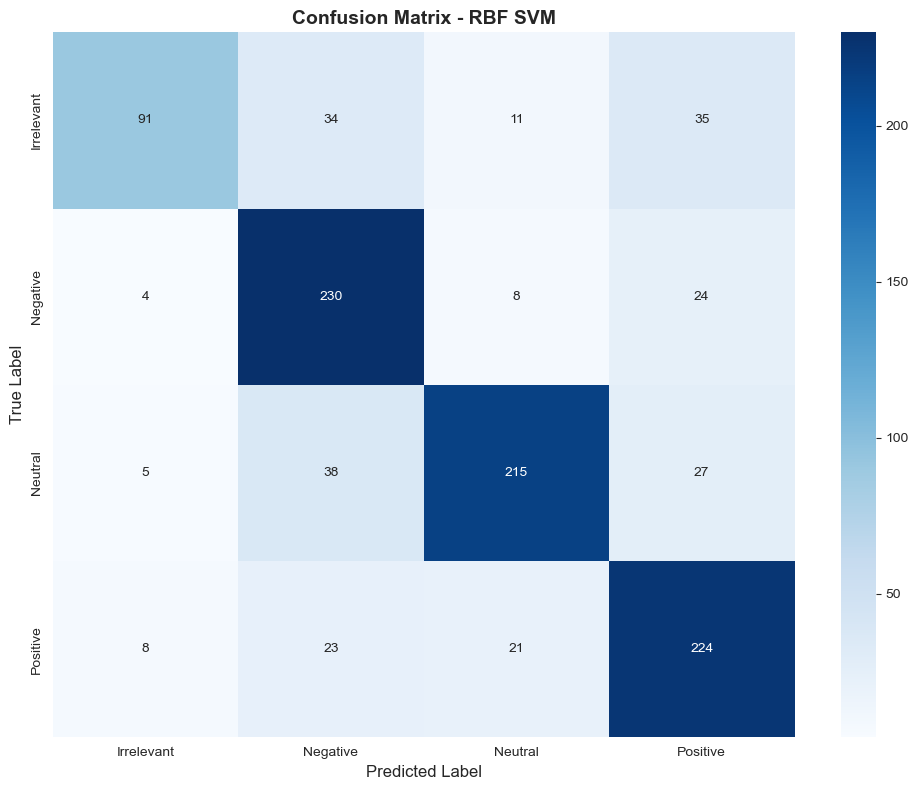


🎯 ROC-AUC Score: 0.9293 (macro)


In [9]:
# ============================================================================
# STEP 8: TRAIN RBF SVM (Optional!@)
# ============================================================================
print("\n[8] Training RBF SVM (this may take longer)...")
print("   Note: RBF SVM is slower but can capture non-linear patterns")
start_time = time.time()

svm_rbf_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, 
                    probability=True, cache_size=500)

# Train on a subset if full dataset is too large
if X_train.shape[0] > 10000:
    print(f"   Training on subset of 10,000 samples for speed...")
    from sklearn.model_selection import train_test_split
    X_train_sub, _, y_train_sub, _ = train_test_split(
        X_train, y_train, train_size=10000, random_state=42, stratify=y_train
    )
    svm_rbf_model.fit(X_train_sub, y_train_sub)
else:
    svm_rbf_model.fit(X_train, y_train)

svm_rbf_time = time.time() - start_time
print(f"   ✓ Training completed in {svm_rbf_time:.2f} seconds")

svm_rbf_results = evaluate_model(svm_rbf_model, X_test, y_test, "RBF SVM")


 NEW MODELS COMPARISON

📊 Performance Summary:
        Model  Accuracy  F1-Score  Training Time (s)
   Linear SVM  0.956914  0.956586           3.543061
      RBF SVM  0.761523  0.747868         150.634681
Random Forest  0.512024  0.427111           1.542279


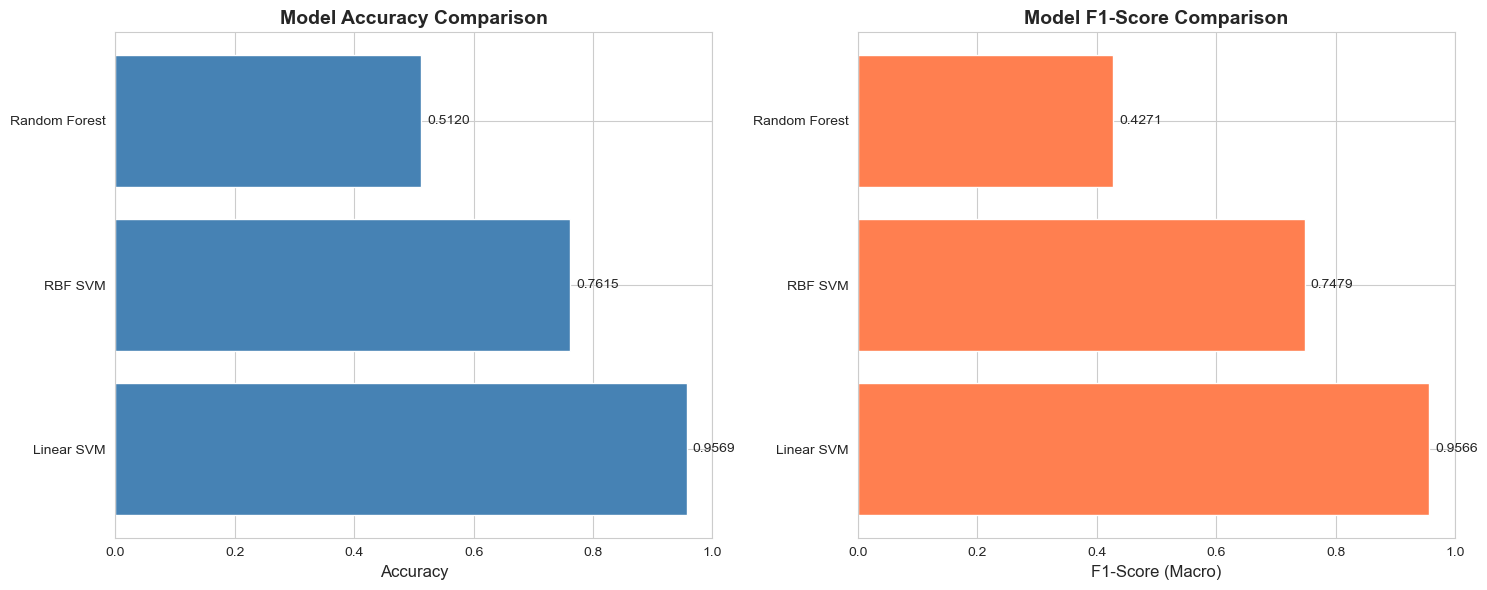


🏆 BEST MODEL: Linear SVM
   Accuracy: 0.9569 (95.69%)
   F1-Score: 0.9566


In [11]:
# ============================================================================
# STEP 9: COMPARE ALL MODELS
# ============================================================================
print("\n" + "="*70)
print(" NEW MODELS COMPARISON")
print("="*70)

comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'Linear SVM', 'RBF SVM'],
    'Accuracy': [
        rf_results['accuracy'],
        svm_linear_results['accuracy'],
        svm_rbf_results['accuracy']
    ],
    'F1-Score': [
        rf_results['f1_score'],
        svm_linear_results['f1_score'],
        svm_rbf_results['f1_score']
    ],
    'Training Time (s)': [rf_time, svm_linear_time, svm_rbf_time]
})

comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

print("\n📊 Performance Summary:")
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy
axes[0].barh(comparison_df['Model'], comparison_df['Accuracy'], color='steelblue')
axes[0].set_xlabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlim([0, 1])
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0].text(v + 0.01, i, f'{v:.4f}', va='center')

# F1-Score
axes[1].barh(comparison_df['Model'], comparison_df['F1-Score'], color='coral')
axes[1].set_xlabel('F1-Score (Macro)', fontsize=12)
axes[1].set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_xlim([0, 1])
for i, v in enumerate(comparison_df['F1-Score']):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print(f"🏆 BEST MODEL: {comparison_df.iloc[0]['Model']}")
print(f"   Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f} ({comparison_df.iloc[0]['Accuracy']*100:.2f}%)")
print(f"   F1-Score: {comparison_df.iloc[0]['F1-Score']:.4f}")
print("="*70)

In [12]:
!pip install xgboost


 TRAINING XGBOOST MODEL

[1] Preparing data for XGBoost...
   Label mapping: {'Irrelevant': np.int64(0), 'Negative': np.int64(1), 'Neutral': np.int64(2), 'Positive': np.int64(3)}

[2] Training XGBoost Classifier...
   ✓ Training completed in 158.17 seconds

[3] Evaluating XGBoost Model...

 EVALUATING: XGBoost

📊 Overall Metrics:
   Accuracy:  0.7305 (73.05%)
   F1-Score:  0.7260 (macro)

📋 Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.88      0.58      0.70       171
    Negative       0.64      0.85      0.73       266
     Neutral       0.82      0.64      0.72       285
    Positive       0.72      0.81      0.76       276

    accuracy                           0.73       998
   macro avg       0.76      0.72      0.73       998
weighted avg       0.75      0.73      0.73       998



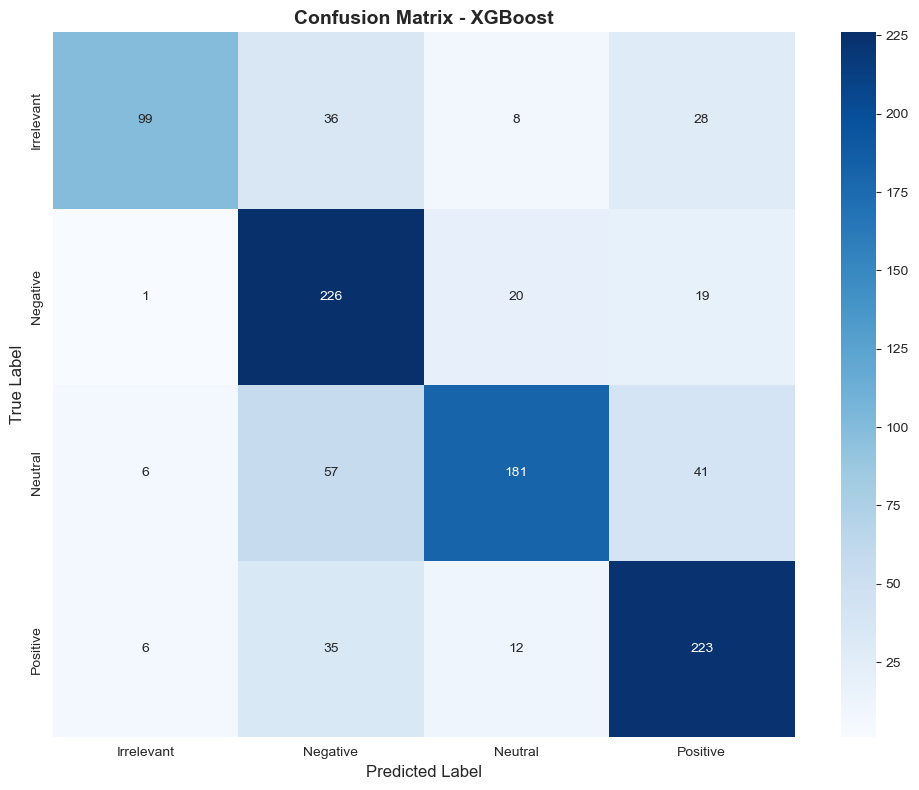


🎯 ROC-AUC Score: 0.9226 (macro)


In [13]:
print("\n" + "="*70)
print(" TRAINING XGBOOST MODEL")
print("="*70)

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

print("\n[1] Preparing data for XGBoost...")

# XGBoost needs numeric labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(f"   Label mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

print("\n[2] Training XGBoost Classifier...")
start_time = time.time()

# XGBoost model with optimized parameters for text classification
xgb_model = xgb.XGBClassifier(
    n_estimators=200,           # Number of trees
    max_depth=6,                # Maximum tree depth
    learning_rate=0.1,          # Learning rate
    subsample=0.8,              # Subsample ratio of training data
    colsample_bytree=0.8,       # Subsample ratio of features
    objective='multi:softmax',  # Multi-class classification
    num_class=4,                # 4 sentiment classes
    random_state=42,
    n_jobs=-1,                  # Use all CPU cores
    eval_metric='mlogloss',     # Metric for multi-class
    tree_method='hist'          # Faster training
)

# Train the model
xgb_model.fit(
    X_train, 
    y_train_encoded,
    verbose=False
)

xgb_time = time.time() - start_time
print(f"   ✓ Training completed in {xgb_time:.2f} seconds")

# Create a wrapper for evaluation (decode predictions back to original labels)
class XGBoostWrapper:
    def __init__(self, model, label_encoder):
        self.model = model
        self.label_encoder = label_encoder
        self.classes_ = label_encoder.classes_
    
    def predict(self, X):
        y_pred_encoded = self.model.predict(X)
        return self.label_encoder.inverse_transform(y_pred_encoded.astype(int))
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)

xgb_wrapped = XGBoostWrapper(xgb_model, label_encoder)

print("\n[3] Evaluating XGBoost Model...")
xgb_results = evaluate_model(xgb_wrapped, X_test, y_test, "XGBoost")


 XGBOOST FEATURE IMPORTANCE

📊 Top 20 Most Important Features:
        feature  importance
            fix    0.005150
          creed    0.004235
        details    0.003693
        servers    0.003259
            why    0.002697
       occurred    0.002635
         earned    0.002616
         player    0.002525
           wait    0.002372
        johnson    0.002298
johnson johnson    0.002246
         amazon    0.002222
    eamaddennfl    0.002070
        excited    0.002003
      check out    0.001906
          worst    0.001866
            com    0.001841
            fun    0.001755
          sucks    0.001736
          thank    0.001630


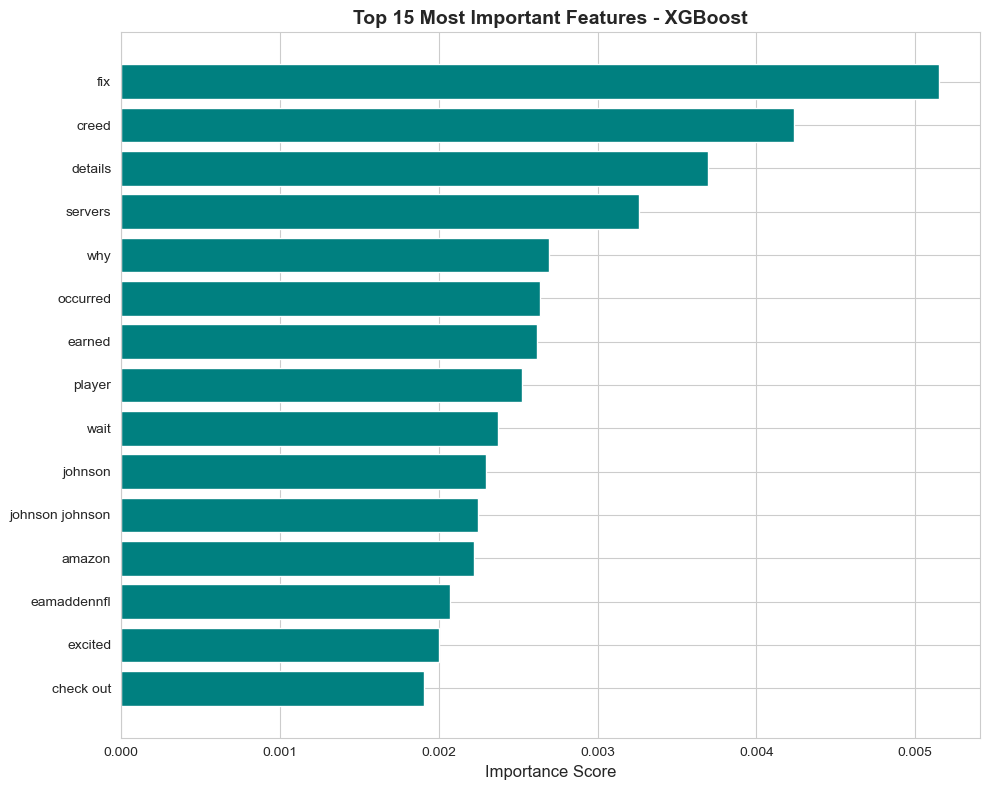


✨ These words/phrases have the most impact on sentiment classification!


In [14]:
print("\n" + "="*70)
print(" XGBOOST FEATURE IMPORTANCE")
print("="*70)

# Get feature importance
feature_importance = xgb_model.feature_importances_

# Get feature names
feature_names = tfidf.get_feature_names_out()

# Create dataframe of top features
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False).head(20)

print("\n📊 Top 20 Most Important Features:")
print(importance_df.to_string(index=False))

# Visualize top 15 features
plt.figure(figsize=(10, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='teal')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 15 Most Important Features - XGBoost', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n✨ These words/phrases have the most impact on sentiment classification!")